## NLP Disaster Tweet Classification (Kaggle Competition)

The goal of this competition is to predict whether a given tweet is talking about a real disaster or not.

In [1]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras_core as keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
import keras_hub

from sklearn.metrics import f1_score, accuracy_score, auc, roc_curve

from keras.optimizers import Adam

from sklearn.model_selection import train_test_split


Using TensorFlow backend


## The data

the dataset we're using was provided by Kaggle. Each row contains the text of a tweet, a keyword (may be blank), and the location of where the tweet was made. The training data also contains a 'target' column which will be a '1' if the tweet is about a real disaster and '0' if not.

Import the data into train and test dataframes. Remove all NA rows from each dataset

In [33]:
df_train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
df_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

df_train = df_train.dropna()

## EDA

In [4]:
df_train.head()

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0


In [5]:
df_train.describe()

,id,target
count,5080.000000,5080.000000
mean,5407.112598,0.432283
std,3116.359041,0.495442
min,48.000000,0.000000
25%,2728.750000,0.000000
50%,5360.500000,0.000000
75%,8086.000000,1.000000
max,10833.000000,1.000000


['Disaster', 'Not Disaster'] [2196, 2884]


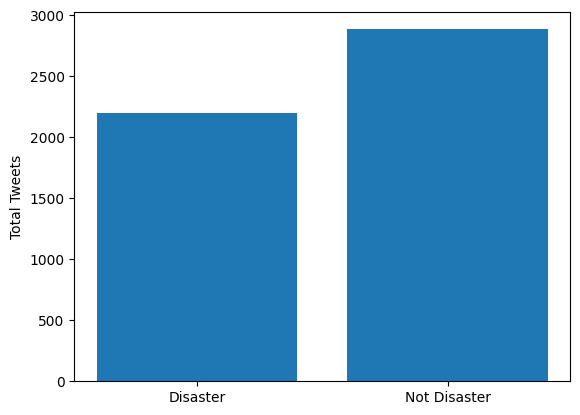

In [6]:
disaster = (df_train['target'] == 1).sum()

non_disaster = (df_train['target'] == 0).sum()

x = ['Disaster', 'Not Disaster']
y = [disaster, non_disaster]
print(x,y)

plt.bar(x,y)

plt.ylabel('Total Tweets')
plt.show()


In [7]:
df_train['text_length'] = df_train['text'].apply(len)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


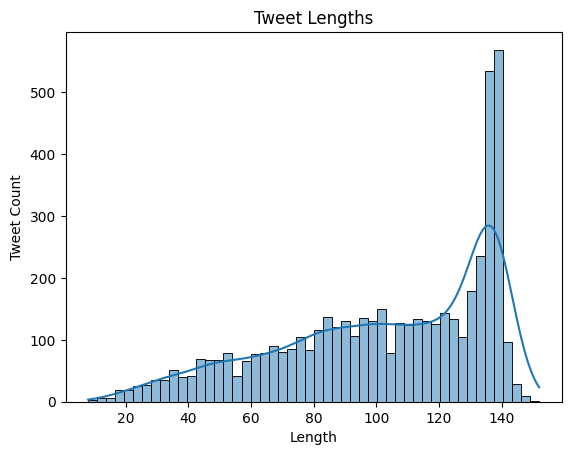

In [8]:
sns.histplot(df_train['text_length'], bins=50, kde=True)
plt.title('Tweet Lengths')
plt.xlabel('Length')
plt.ylabel('Tweet Count')
plt.show()

## Building the first Model

The first model will use a DistilBert Classifier from the keras_nlp libary. The data will be preprocessed by DistilBertPreprocessor which tokenizes the input data, pack the inputs together and construct a dictionary that will be passed to the model.

I tried increasing and decreasing the learning rate and found 0.0001 was the sweet spot. Increasing it led to a significant drop in accuracy and f1 scores. Lowering the learning rate further did not significantly improve the model's results while decreasing performance significantly.

I also settled on 10 epochs as running 20, did not improve accuracy or f1 score, but took far longer to train.


In [16]:
BATCH_SIZE = 32
VAL_SPLIT = 0.2
LEARNING_RATE = 0.0001
EPOCHS = 10
AUTO = tf.data.experimental.AUTOTUNE

opt = Adam(learning_rate=LEARNING_RATE)
opt2 = Adam(learning_rate=LEARNING_RATE)

In [34]:
X = df_train["text"]
y = df_train["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)

X_test = df_test["text"]

In [18]:
pre = keras_nlp.models.DistilBertPreprocessor.from_preset("distil_bert_base_en_uncased",
                                                        sequence_length=160,
                                                        name="tweet_preprocessor"
                                                        )

classifier = keras_nlp.models.DistilBertClassifier.from_preset("distil_bert_base_en_uncased",
                                                               preprocessor = pre, 
                                                               num_classes=2)

classifier.summary()

Preprocessor: "tweet_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)                   │                       Vocab size: 30,522 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "distil_bert_text_classifier_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item_1 (GetItem)          │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item_1[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Compile and fit the model

classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=opt,
    metrics= ["accuracy"]
)

# Fit the model with the hyperparameters set earlier
history = classifier.fit(x=X_train,
                         y=y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS, 
                         validation_data=(X_val, y_val)
                        )

Epoch 1/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 96s 271ms/step - accuracy: 0.7358 - loss: 0.5441 - val_accuracy: 0.8169 - val_loss: 0.4440
Epoch 2/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 31s 245ms/step - accuracy: 0.8522 - loss: 0.3779 - val_accuracy: 0.7972 - val_loss: 0.4357
Epoch 3/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 31s 246ms/step - accuracy: 0.9112 - loss: 0.2529 - val_accuracy: 0.7402 - val_loss: 0.5978
Epoch 4/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 31s 246ms/step - accuracy: 0.9361 - loss: 0.1942 - val_accuracy: 0.8081 - val_loss: 0.6229
Epoch 5/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 31s 246ms/step - accuracy: 0.9480 - loss: 0.1348 - val_accuracy: 0.8041 - val_loss: 0.7219
Epoch 6/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 31s 246ms/step - accuracy: 0.9651 - loss: 0.1029 - val_accuracy: 0.7992 - val_loss: 0.7969
Epoch 7/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 31s 246ms/step - accuracy: 0.9752 - loss: 0.0860 - val_accuracy: 0.7913 - val_loss: 0.9453
Epoch 8/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 31s 246ms/step - accuracy: 0.9722 - loss: 0

In [20]:
y_train

5732    1
3873    0
3382    0
6664    0
3233    1
       ..
6604    1
709     0
4602    0
5609    1
1312    0
Name: target, Length: 4064, dtype: int64

127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step
Training Dataset F1 Score: 0.9794500723589001


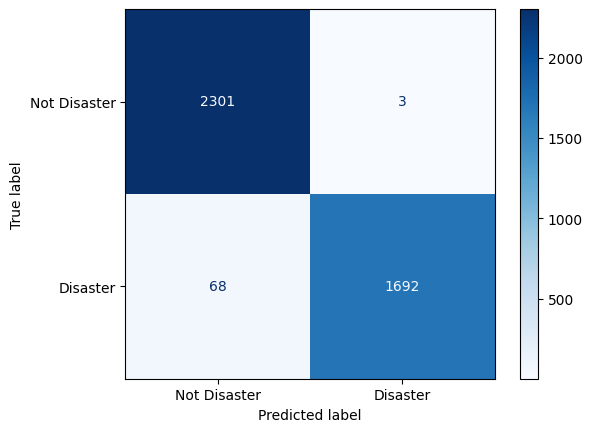

In [21]:
#predict x train
y_pred_train = classifier.predict(X_train)


#show a confusion matrix for the prediction
disp = ConfusionMatrixDisplay.from_predictions(
    y_train,
    np.argmax(y_pred_train, axis=1),
    display_labels=["Not Disaster","Disaster"],
    cmap=plt.cm.Blues
)

#include f1 score above the matrix
tn, fp, fn, tp = confusion_matrix(y_train, np.argmax(y_pred_train, axis=1)).ravel()
f1 = tp / (tp+((fn+fp)/2))

print("Training Dataset F1 Score: " + str(f1))

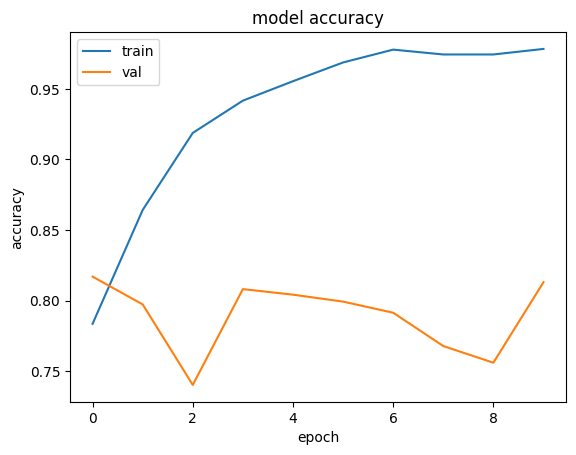

In [22]:
#plot the model accuracy over epochs

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

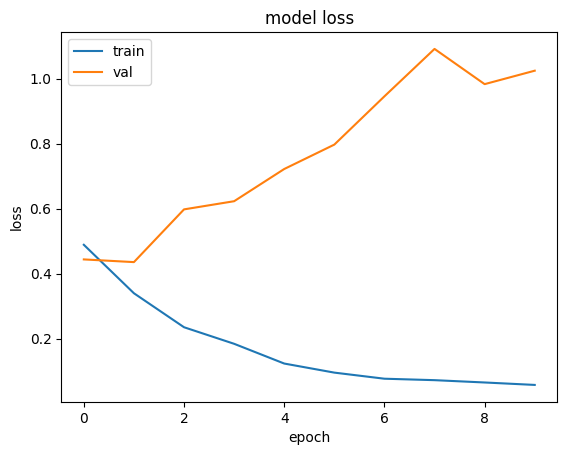

In [23]:
#plot model's loss over epochs

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [24]:
X = df_train["text"]
y = df_train["target"]

X_train2, X_val2, y_train2, y_val2 = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)

X_test = df_test["text"]

In [25]:
#build a second model using a different classifier

pre2 = keras_hub.models.TextClassifierPreprocessor.from_preset(
    "f_net_base_en",
    sequence_length=160
)

classifier2 = keras_hub.models.FNetTextClassifier.from_preset(
    "f_net_base_en",
    num_classes=2,
    preprocessor=pre2
)

In [26]:
classifier2.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=opt2,
    jit_compile=True,
    metrics=["accuracy"]
)

In [27]:
history2 = classifier2.fit(x=X_train2,
                         y=y_train2,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS, 
                         validation_data=(X_val, y_val)
                        )

Epoch 1/10


I0000 00:00:1733446710.069545    2520 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_47', 28 bytes spill stores, 28 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'copy_fusion_1', 280 bytes spill stores, 284 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_34', 124 bytes spill stores, 124 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_xor_fusion_121', 8 bytes spill stores, 8 bytes spill loads



127/127 ━━━━━━━━━━━━━━━━━━━━ 95s 328ms/step - accuracy: 0.6080 - loss: 0.6588 - val_accuracy: 0.7667 - val_loss: 0.4933
Epoch 2/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 38s 298ms/step - accuracy: 0.7798 - loss: 0.4720 - val_accuracy: 0.7352 - val_loss: 0.5504
Epoch 3/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 38s 298ms/step - accuracy: 0.8525 - loss: 0.3638 - val_accuracy: 0.7126 - val_loss: 0.6632
Epoch 4/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 38s 298ms/step - accuracy: 0.8855 - loss: 0.2985 - val_accuracy: 0.7539 - val_loss: 0.6021
Epoch 5/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 39s 303ms/step - accuracy: 0.8835 - loss: 0.2913 - val_accuracy: 0.7904 - val_loss: 0.5324
Epoch 6/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 38s 298ms/step - accuracy: 0.9214 - loss: 0.2193 - val_accuracy: 0.7923 - val_loss: 0.6239
Epoch 7/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 38s 298ms/step - accuracy: 0.9336 - loss: 0.1776 - val_accuracy: 0.7805 - val_loss: 0.6967
Epoch 8/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 38s 297ms/step - accuracy: 0.9562 - loss: 0.1312 - val

127/127 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step
Training Dataset F1 Score: 0.9857387335995437


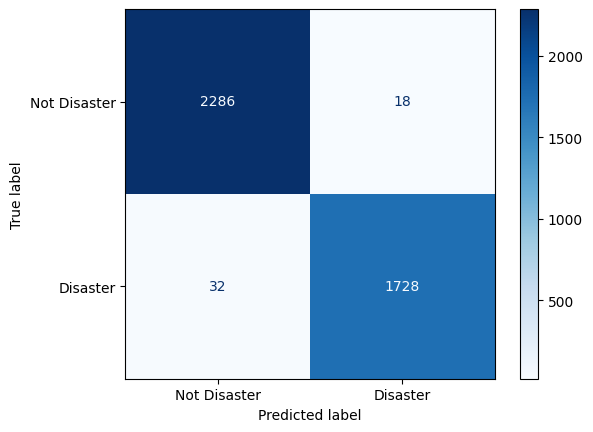

In [29]:
#display the confusion matrix and f1 score for the second model

y_pred_train2 = classifier2.predict(X_train2)

disp = ConfusionMatrixDisplay.from_predictions(
    y_train2,
    np.argmax(y_pred_train2, axis=1),
    display_labels=["Not Disaster","Disaster"],
    cmap=plt.cm.Blues
)

tn, fp, fn, tp = confusion_matrix(y_train2, np.argmax(y_pred_train2, axis=1)).ravel()
f12 = tp / (tp+((fn+fp)/2))

print("Training Dataset F1 Score: " + str(f12))

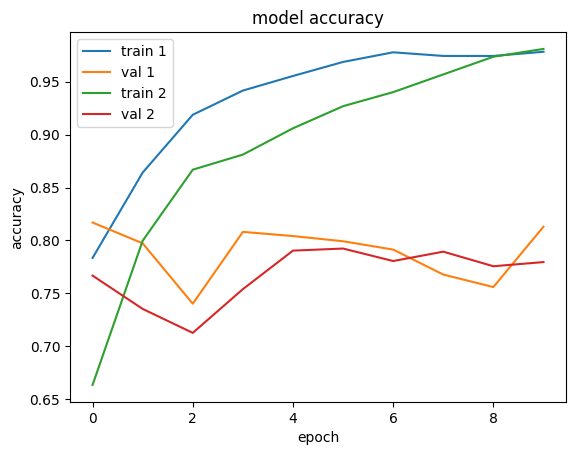

In [30]:
#plot the accuracy of the first and second models for comparison

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train 1', 'val 1', 'train 2', 'val 2'], loc='upper left')
plt.show()

## Conclusion¶

After comparing the two models, they are very close in terms of performance. The f1 scores and accuracy on the training data are extremely close. However, the first model was more accurate at predicting the validation data. For this reason, going forward, I would continue to build on the first model. The other issue with the second model is that it took about twice as long to train as the first model.

To improve the first model, I would do more preprocessing of the datasets to remove stop words. The DistilBertPreprocessor tokenizes the input data, but it does not remove commonly used words.


In [31]:
final_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
final_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [35]:
final_submission["target"] = np.argmax(classifier.predict(X_test), axis=1)

102/102 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step


In [36]:
final_submission.to_csv("submission.csv", index=False)